<a href="https://colab.research.google.com/github/aarondelgiudice/thinkful_data_bootcamp/blob/master/unit_7/capstone/RD/7_1b_Model_Audio_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Audio Features
#### Table of Contents
- Import Data
  - Define Data and target
  - EDA
  - Scale Data
- Model Selection
  - L1/L2 Regularization
  - Decision Tree
  - K-Nearest Neighbors
  - Random Forest
  - Multilayer Processing
  - Gradient Boosting
- Model Tuning
  - Hyperparameter Optimization
- Final Model
- Conclusion

## Import Data

In [0]:
# load packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [0]:
#from google.colab import files
#files.upload()

In [3]:
filename = "spotify_test_data"
df_af = pd.read_csv(filename + ".csv", index_col=0)

df_af.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,target,tempo,time_signature,track_href,type,uri,valence,track_names,artist_names,album_names,release_dates,popularity,explicit
0,0.1730,https://api.spotify.com/v1/audio-analysis/7eEl...,0.796,197236,0.467,7eElVgPcxDqmgGrSwVFI74,0.004110,6,0.1260,-10.369,1,0.1810,1,107.901,4,https://api.spotify.com/v1/tracks/7eElVgPcxDqm...,audio_features,spotify:track:7eElVgPcxDqmgGrSwVFI74,0.516,Sober,Lorde,Melodrama,2017-06-16,59,True
1,0.2870,https://api.spotify.com/v1/audio-analysis/02oA...,0.771,189796,0.431,02oAUzv4M0ItuTDy2RT3IT,0.000003,10,0.0934,-5.423,1,0.0577,1,107.047,4,https://api.spotify.com/v1/tracks/02oAUzv4M0It...,audio_features,spotify:track:02oAUzv4M0ItuTDy2RT3IT,0.268,Homemade Dynamite,Lorde,Melodrama,2017-06-16,60,True
2,0.2390,https://api.spotify.com/v1/audio-analysis/5q4B...,0.664,271088,0.382,5q4BpnMrYEFzLO0dYODj6J,0.007490,0,0.0943,-9.977,1,0.0470,1,123.214,4,https://api.spotify.com/v1/tracks/5q4BpnMrYEFz...,audio_features,spotify:track:5q4BpnMrYEFzLO0dYODj6J,0.126,The Louvre,Lorde,Melodrama,2017-06-16,61,False
3,0.9200,https://api.spotify.com/v1/audio-analysis/6Kkt...,0.587,171728,0.229,6Kkt27YmFyIFrcX3QXFi2o,0.000000,10,0.1000,-11.254,0,0.1280,1,75.670,4,https://api.spotify.com/v1/tracks/6Kkt27YmFyIF...,audio_features,spotify:track:6Kkt27YmFyIFrcX3QXFi2o,0.379,Liability,Lorde,Melodrama,2017-06-16,69,False
4,0.0328,https://api.spotify.com/v1/audio-analysis/1Dp7...,0.487,367391,0.445,1Dp7JGFNjvg8Nk0CtMCcnr,0.010400,1,0.0778,-10.959,0,0.1130,1,97.031,4,https://api.spotify.com/v1/tracks/1Dp7JGFNjvg8...,audio_features,spotify:track:1Dp7JGFNjvg8Nk0CtMCcnr,0.180,Hard Feelings/Loveless,Lorde,Melodrama,2017-06-16,60,True


In [0]:
# define dataframes to store results
model_desc = []
model_score = pd.DataFrame()

# define supervised modeling function
def supervised_clf(model, data, target, test_size=0.25, stratify=None, cv=5):
  """
  """
  #from sklearn.model_selection import train_test_split, cross_val_score
  
  X_train, X_test, y_train, y_test = train_test_split(
      data, target, test_size=test_size, stratify=stratify, random_state=42)
  
  model = model.fit(X_train, y_train)
  train_score = model.score(X_train, y_train)
  test_score = model.score(X_test, y_test)
  print('\nTraining score:', train_score)
  print('\nValidation score:', test_score)
  
  cv_scores = cross_val_score(model, data, target, cv=cv)
  cv_score = np.round(np.mean(cv_scores)*100, 4)
  variance = np.round(np.var(cv_scores)*100, 4)
  print('\nCross validation: {} +/- {}%'.format(cv_score, variance))
  
  return pd.DataFrame([[train_score, test_score, cv_score, variance]],
                      columns=["train_score", "test_score", "cv_score", "variance"])

In [0]:
def plotting_func(labels_list, data, title_list, num_plots=3, figsize=(15,5)):
  """
  """
  num_plots = range(0,num_plots)
  
  # plot target variable
  fig, axes = plt.subplots(1, len(num_plots), figsize=figsize)
  
  for n in num_plots:
    sns.scatterplot(data[:,0], data[:,1],
                    hue=labels_list[n], ax=axes[n])
    axes[n].set_xlabel(title_list[n])

  fig.suptitle(title_list[-1])
  plt.show;

### Define Data and target

In [0]:
drop_list = ['analysis_url', 'id', 'target', 'track_href', 'type', 'uri',
             'track_names', 'artist_names', 'album_names', 'release_dates']
Data = df_af.drop(drop_list, axis=1)
target = df_af['target']

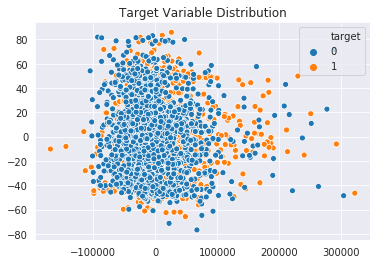

In [7]:
# reduce data to two dimensions
from sklearn.decomposition import PCA
Data_2D = PCA(n_components=2).fit_transform(Data)

sns.scatterplot(Data_2D[:,0], Data_2D[:,1], hue=target)
plt.title("Target Variable Distribution")
plt.show;

### EDA

In [8]:
print(Data.shape)
Data.head()

(3502, 15)


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,explicit
0,0.1730,0.796,197236,0.467,0.004110,6,0.1260,-10.369,1,0.1810,107.901,4,0.516,59,True
1,0.2870,0.771,189796,0.431,0.000003,10,0.0934,-5.423,1,0.0577,107.047,4,0.268,60,True
2,0.2390,0.664,271088,0.382,0.007490,0,0.0943,-9.977,1,0.0470,123.214,4,0.126,61,False
3,0.9200,0.587,171728,0.229,0.000000,10,0.1000,-11.254,0,0.1280,75.670,4,0.379,69,False
4,0.0328,0.487,367391,0.445,0.010400,1,0.0778,-10.959,0,0.1130,97.031,4,0.180,60,True


In [9]:
Data.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
count,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000
mean,0.273028,0.570359,226008.314106,0.624774,0.055689,5.308110,0.173327,-7.297160,0.717590,0.058897,122.851039,3.957167,0.442627,30.660194
std,0.272505,0.117471,47687.658649,0.194005,0.181753,3.578098,0.136656,3.173063,0.450236,0.059604,29.567463,0.256075,0.231606,21.996583
min,0.000011,0.061500,57196.000000,0.006150,0.000000,0.000000,0.014300,-30.875000,0.000000,0.022500,48.718000,1.000000,0.030100,0.000000
25%,0.039875,0.499000,196667.250000,0.487000,0.000000,2.000000,0.096225,-8.899000,0.000000,0.031300,99.979250,4.000000,0.261000,9.000000
50%,0.171000,0.575000,218846.500000,0.649000,0.000008,5.000000,0.119000,-6.678500,1.000000,0.038700,122.001000,4.000000,0.424000,32.000000
75%,0.455000,0.647000,245559.000000,0.785000,0.001090,9.000000,0.200750,-5.105000,1.000000,0.057075,142.648000,4.000000,0.611000,48.000000
max,0.994000,0.946000,547733.000000,0.994000,0.970000,11.000000,0.978000,-0.755000,1.000000,0.521000,209.515000,5.000000,0.982000,85.000000


In [10]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3502 entries, 0 to 3501
Data columns (total 15 columns):
acousticness        3502 non-null float64
danceability        3502 non-null float64
duration_ms         3502 non-null int64
energy              3502 non-null float64
instrumentalness    3502 non-null float64
key                 3502 non-null int64
liveness            3502 non-null float64
loudness            3502 non-null float64
mode                3502 non-null int64
speechiness         3502 non-null float64
tempo               3502 non-null float64
time_signature      3502 non-null int64
valence             3502 non-null float64
popularity          3502 non-null int64
explicit            3502 non-null bool
dtypes: bool(1), float64(9), int64(5)
memory usage: 413.8 KB


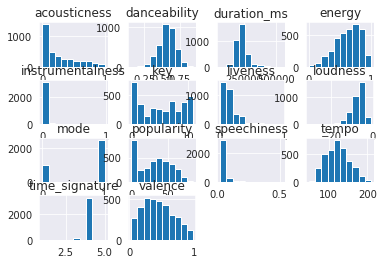

In [11]:
# drop boolean
Data.drop(['explicit'], axis=1).hist();

### Scale Data

In [12]:
Data_raw = Data.copy()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Data = scaler.fit_transform(Data_raw.drop(['explicit'], axis=1))
Data = pd.DataFrame(Data, columns=Data_raw.drop(['explicit'], axis=1).columns)
Data['explicit'] = Data_raw['explicit']
Data.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
count,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000
mean,0.274668,0.575307,0.344138,0.626233,0.057411,0.482555,0.165017,0.782797,0.717590,0.073013,0.461035,0.739292,0.433373,0.360708
std,0.274153,0.132811,0.097215,0.196391,0.187375,0.325282,0.141803,0.105347,0.450236,0.119567,0.183881,0.064019,0.243310,0.258783
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040105,0.494630,0.284324,0.486764,0.000000,0.181818,0.085011,0.729615,0.000000,0.017653,0.318795,0.750000,0.242567,0.105882
50%,0.172023,0.580554,0.329538,0.650757,0.000008,0.454545,0.108644,0.803337,1.000000,0.032497,0.455749,0.750000,0.413804,0.376471
75%,0.457740,0.661956,0.383993,0.788429,0.001124,0.818182,0.193473,0.855578,1.000000,0.069358,0.584153,0.750000,0.610253,0.564706
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


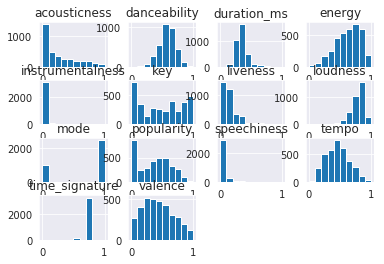

In [13]:
Data.drop(['explicit'], axis=1).hist();

## Model Selection

### L1 Regularization

In [14]:
#from sklearn.linear_model import LogisticRegression
lasso = LogisticRegression(penalty='l1', random_state=42)

model_desc.append("lasso")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=lasso,
                           data=Data,
                           target=target,
                           stratify=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: lasso


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Training score: 0.8293983244478293

Validation score: 0.8207762557077626


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur


Cross validation: 80.9565 +/- 0.2672%


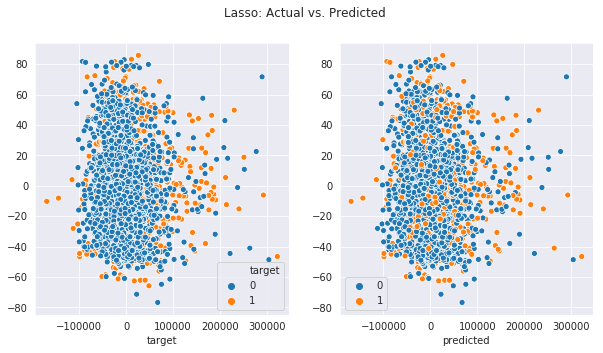

In [15]:
y_pred = lasso.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Lasso: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### L2 Regularization

In [16]:
#from sklearn.linear_model import LogisticRegression
ridge = LogisticRegression(penalty='l2', random_state=42)
model_desc.append("ridge")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=ridge,
                           data=Data,
                           target=target,
                           stratify=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: ridge

Training score: 0.8221629855293222

Validation score: 0.8116438356164384

Cross validation: 80.5853 +/- 0.27%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

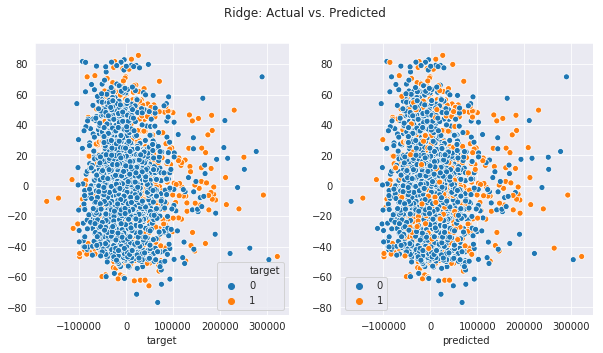

In [17]:
y_pred = ridge.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Ridge: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Decision Tree

In [18]:
#from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42)
model_desc.append("decision tree")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=tree,
                           data=Data,
                           target=target,
                           stratify=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: decision tree

Training score: 0.9996191926884996

Validation score: 0.8264840182648402

Cross validation: 80.0435 +/- 0.4166%


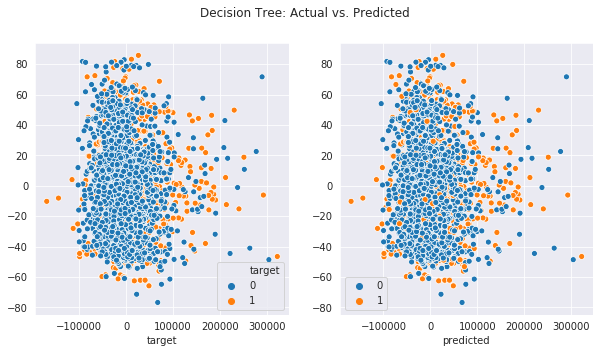

In [19]:
y_pred = tree.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Decision Tree: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### K-Nearest Neighbors

In [20]:
#from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(3)
model_desc.append("k-nearest neighbors")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=knn,
                           data=Data,
                           target=target,
                           stratify=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: k-nearest neighbors

Training score: 0.8842345773038842

Validation score: 0.7876712328767124

Cross validation: 76.9301 +/- 0.3151%


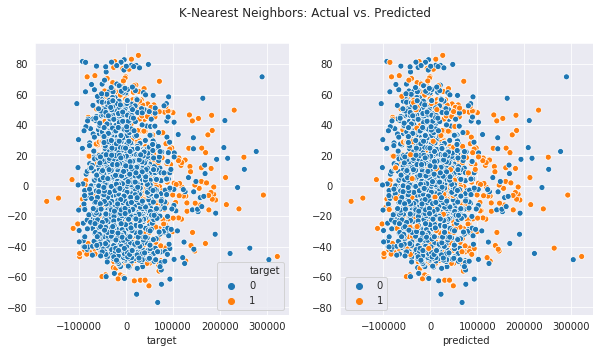

In [21]:
y_pred = knn.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "K-Nearest Neighbors: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Random Forest

In [22]:
#from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
model_desc.append("random forest")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=rfc,
                           data=Data,
                           target=target,
                           stratify=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: random forest

Training score: 0.9996191926884996

Validation score: 0.8767123287671232

Cross validation: 85.6133 +/- 0.4442%


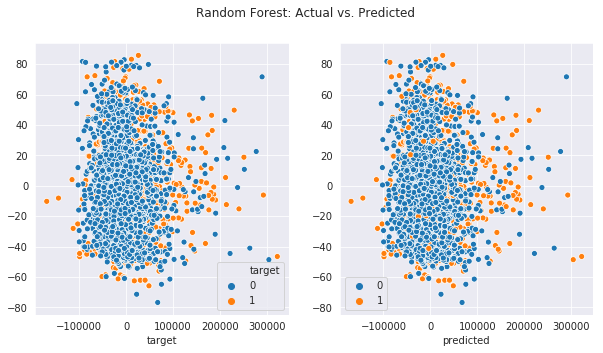

In [23]:
y_pred = rfc.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Random Forest: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Multilayer Processing

In [24]:
#from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
model_desc.append("multilayer processing")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=mlp,
                           data=Data,
                           target=target,
                           stratify=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: multilayer processing


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Training score: 0.8488194973343488

Validation score: 0.8253424657534246


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Cross validation: 81.2127 +/- 0.2507%


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


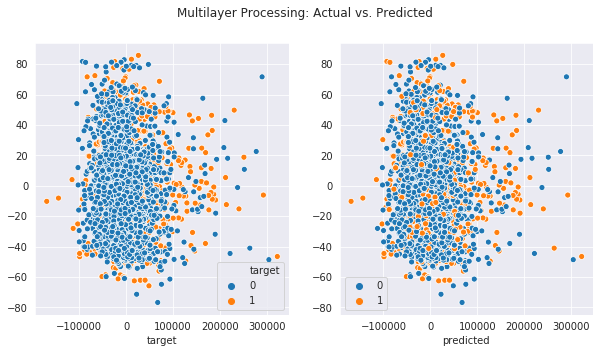

In [25]:
y_pred = mlp.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Multilayer Processing: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Gradient Boosting

In [26]:
#from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(learning_rate=0.1)
model_desc.append("gradient boosting")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=gbc,
                           data=Data,
                           target=target,
                           stratify=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: gradient boosting

Training score: 0.9181264280274182

Validation score: 0.8778538812785388

Cross validation: 85.0409 +/- 0.3689%


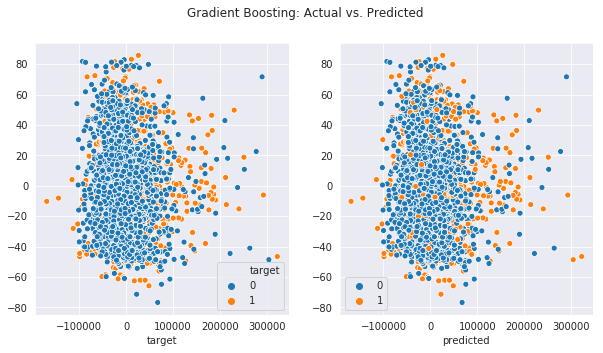

In [27]:
y_pred = gbc.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Gradient Boosting: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Assessment

In [28]:
model_score[["cv_score", "variance"]].describe()

,cv_score,variance
count,7.000000,7.000000
mean,81.483186,0.333243
std,2.990965,0.077497
min,76.930100,0.250700
25%,80.314400,0.268600
50%,80.956500,0.315100
75%,83.126800,0.392750
max,85.613300,0.444200


In [29]:
model_score = pd.concat([pd.Series(model_desc, name="model"), model_score], axis=1)
model_score.sort_values(by=["cv_score"], ascending=False).head(5)

,model,train_score,test_score,cv_score,variance
4,random forest,0.999619,0.876712,85.6133,0.4442
6,gradient boosting,0.918126,0.877854,85.0409,0.3689
5,multilayer processing,0.848819,0.825342,81.2127,0.2507
0,lasso,0.829398,0.820776,80.9565,0.2672
1,ridge,0.822163,0.811644,80.5853,0.2700


## Model Tuning

### Hyperparmeter Optimization

In [30]:
#from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(learning_rate=0.1)
gbc = gbc.fit(Data, target)
gbc.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [0]:
# learning rate 
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'auto', None]
# Maximum number of levels in tree
max_depths = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depths.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
# boosting
warm_start = [True, False]

# Create the random grid
param_grid = {'learning_rate': learning_rates,
              'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depths,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'warm_start': warm_start}

In [0]:
# split data 
X_train, X_test, y_train, y_test = train_test_split(
    Data, target, test_size=0.25, stratify=target, random_state=42)

# sample data for parameter search
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_train, y_train, test_size=0.5, random_state=42, stratify=y_train)

In [33]:
%%time
from sklearn.model_selection import RandomizedSearchCV

gbc = GradientBoostingClassifier()

gbc_rs = RandomizedSearchCV(gbc, param_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

gbc_rs.fit(X_train_sample, y_train_sample)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished


CPU times: user 2.16 s, sys: 76.9 ms, total: 2.24 s
Wall time: 1min 16s


In [34]:
gbc_rs.best_params_

{'learning_rate': 0.05,
 'max_depth': 110,
 'max_features': 'log2',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.4,
 'n_estimators': 700,
 'warm_start': False}

## Final Model

In [0]:
# hard code best parameters
best_params = {'learning_rate': 0.01,
               'max_depth': 90,
               'max_features': 'auto',
               'min_samples_leaf': 0.1,
               'min_samples_split': 0.7000000000000001,
               'n_estimators': 900,
               'warm_start': False}


In [36]:
best_params = gbc_rs.best_params_
gbc = GradientBoostingClassifier(**best_params, random_state=42)
supervised_clf(gbc, Data, target, stratify=target)


Training score: 0.9097486671744097

Validation score: 0.8664383561643836

Cross validation: 84.2974 +/- 0.3252%


,train_score,test_score,cv_score,variance
0,0.909749,0.866438,84.2974,0.3252


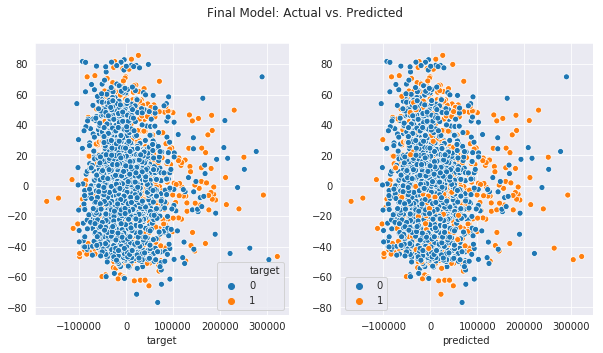

In [37]:
y_pred = gbc.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Final Model: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

## Conclusion